# Interferon and cell cycle ignatures

In [57]:
import scanpy as sc
import muon as mu
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from statsmodels.stats.multitest import fdrcorrection

### Read MuData

In [18]:
def get_specific_gene(mdata, gene, ct):
    import seaborn as sns
    df = mdata.obs.copy()
    df = df.query(f'annotation_merged == "{ct}"')
    df['expr'] = mdata.mod['rna'][mdata.obs['annotation_merged']==ct, gene].X.todense().A1
    expr1 = df.query('pSS == 0').expr.values
    expr2 = df.query('pSS == 1').expr.values
    sns.barplot(x='pSS', y='expr', data=df)
    return expr1, expr2



In [ ]:
get_specific_gene(mdata, 'ISG15')

In [ ]:
ct_list = mdata.obs.annotation_merged.drop_duplicates().tolist()

### ISG heatmap

In [263]:
selected_genes = """DDX60, DHX58, GBP1, IFI27, IFI35, IFIH1, IFIT1, IFIT2, IFIT3, IFIT5, IFITM1, IFITM3, IRF7, IRF9, ISG15, ISG20, LAMP3, MX1, OAS1, OAS2, OAS3, OASL, OTOF, SP140, STAT1, STAT2, TAP1, TRIM22, TRIM5, USP18, USP41""".split(', ')

In [264]:
ctrl_genes = ['ACTB', 'PGK1', 'GAPDH', 'PPIA', 'RPL13A', 'RPLP0', 'TUBB']
# ctrl_genes = list(np.random.choice(mdata.mod['rna'].var.index, 10))

In [265]:
selected_genes = list(set(mdata.mod['rna'].raw.var.index) & set(selected_genes)) + ctrl_genes

In [266]:
expr = pd.DataFrame(
    mdata.mod['rna'][:, selected_genes].X.toarray(),
    index = mdata.obs.index,
    columns = selected_genes)
expr['ct'] = mdata.obs['annotation_merged'].tolist()
expr['fs'] = mdata.obs['fs'].clip(lower=0).tolist()
expr['siccaid'] = mdata.obs['siccaid'].tolist()
expr = expr.sort_values(['fs'])

In [267]:
ct_list = mdata.obs['annotation_merged'].value_counts().index.tolist()#mdata.obs.annotation_merged.drop_duplicates().tolist()

In [268]:
ct = 'Naive CD4+ T'

In [269]:
def get_sc_fs_heatmap(ct, vmin, vmax):

    num_zero = expr.query(f'ct == "{ct}" & fs == 0').shape[0]
    heatmap = expr.query(f'ct == "{ct}"')[selected_genes]
    heatmap = heatmap - heatmap.mean(axis=0)
    heatmap = heatmap / heatmap.std(axis=0)
    ma_num = int(heatmap.shape[0]/70)
    heatmap = heatmap.rolling(window=ma_num, min_periods=1).mean()
    sns.heatmap(heatmap.T, vmax=vmax, vmin=vmin, center=0, cmap='coolwarm', yticklabels=1)
    plt.plot([num_zero, num_zero], [0, len(selected_genes)], '--', color='k', lw=3)
    plt.plot([0, heatmap.shape[0]], [len(selected_genes)-len(ctrl_genes), len(selected_genes)-len(ctrl_genes)], '--', color='k', lw=3)
    plt.xticks([])
    plt.yticks(fontsize=7)
    plt.title(ct)

In [270]:
fav_cts = ['Classical Mono', 'Non classical Mono', 'CM CD4+ T', 'Transitional B']

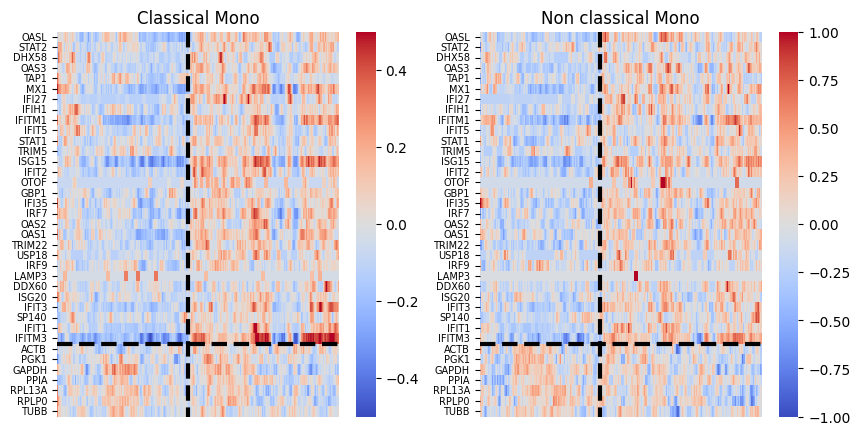

In [240]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
get_sc_fs_heatmap('Classical Mono', vmax=0.5, vmin=-0.5)
plt.subplot(1, 2, 2)
get_sc_fs_heatmap('Non classical Mono', vmax=1, vmin=-1)

plt.savefig('monocyte_isg.png', bbox_inches='tight')

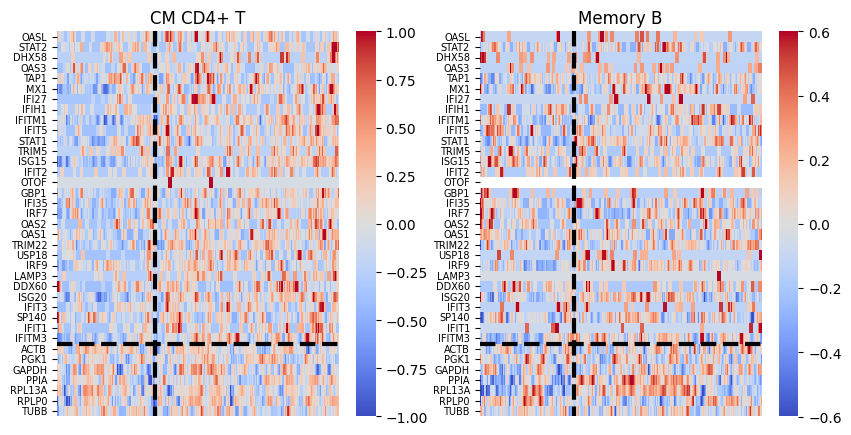

In [275]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
get_sc_fs_heatmap('CM CD4+ T', vmax=1, vmin=-1)
plt.subplot(1, 2, 2)
get_sc_fs_heatmap('Memory B', vmax=0.6, vmin=-0.6)

plt.savefig('lymphocyte_isg2.png', bbox_inches='tight')

### Lymphoma heatmap

In [19]:
selected_genes = "CD80, CD86, CD40, CD83, CD69, CD27, CD76, ITGAX, GPR183, CD30, IGHG1, IGHG2, IGHG3, IGHG4, TLR7, TLR8, TLR9, TCF7, TBX21, IL21R".split(', ')

In [20]:
ctrl_genes = ['ACTB', 'PGK1', 'GAPDH', 'PPIA', 'RPL13A', 'RPLP0', 'TUBB']
# ctrl_genes = list(np.random.choice(mdata.mod['rna'].var.index, 10))

In [21]:
selected_genes = list(set(mdata.mod['rna'].raw.var.index) & set(selected_genes)) + ctrl_genes

In [23]:
expr = pd.DataFrame(
    mdata.mod['rna'][:, selected_genes].X.toarray(),
    index = mdata.obs.index,
    columns = selected_genes)
expr['ct'] = mdata.obs['annotation_merged'].tolist()
expr['fs'] = mdata.obs['fs'].clip(lower=0).tolist()
expr['siccaid'] = mdata.obs['siccaid'].tolist()
expr = expr.sort_values(['fs'])

In [24]:
ct_list = mdata.obs['annotation_merged'].value_counts().index.tolist()#mdata.obs.annotation_merged.drop_duplicates().tolist()

In [25]:
def get_sc_fs_heatmap(ct, vmin, vmax):

    num_zero = expr.query(f'ct == "{ct}" & fs == 0').shape[0]
    heatmap = expr.query(f'ct == "{ct}"')[selected_genes]
    heatmap = heatmap - heatmap.mean(axis=0)
    heatmap = heatmap / heatmap.std(axis=0)
    ma_num = int(heatmap.shape[0]/70)
    heatmap = heatmap.rolling(window=ma_num, min_periods=1).mean()
    sns.heatmap(heatmap.T, vmax=vmax, vmin=vmin, center=0, cmap='coolwarm', yticklabels=1)
    plt.plot([num_zero, num_zero], [0, len(selected_genes)], '--', color='k', lw=3)
    plt.plot([0, heatmap.shape[0]], [len(selected_genes)-len(ctrl_genes), len(selected_genes)-len(ctrl_genes)], '--', color='k', lw=3)
    plt.xticks([])
    plt.yticks(fontsize=7)
    plt.title(ct)

In [29]:
for ct in ['Plasma cells']:

    # if 'B' not in ct:
    #     continue
    plt.figure()
    try:
        get_sc_fs_heatmap(ct, -0.5, 0.5)
    except:
        continue

<Figure size 640x480 with 0 Axes>

In [30]:
get_sc_fs_heatmap('Plasma cells', -0.5, 0.5)

ValueError: min_periods 1 must be <= window 0

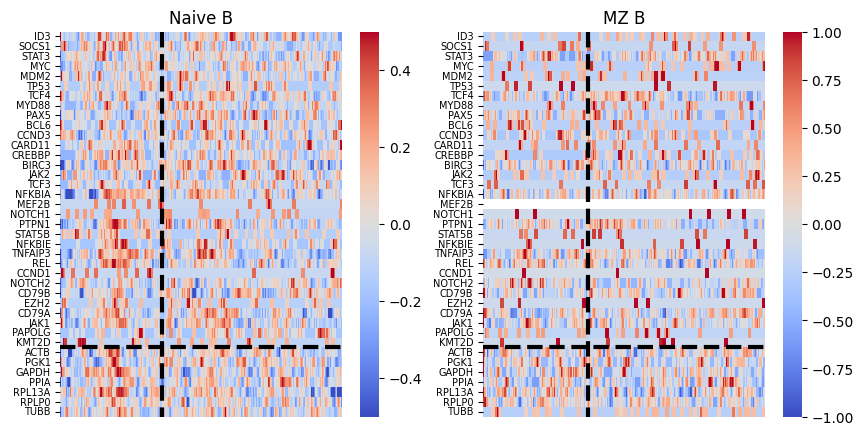

In [262]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
get_sc_fs_heatmap('Naive B', vmax=0.5, vmin=-0.5)
plt.subplot(1, 2, 2)
get_sc_fs_heatmap('MZ B', vmax=1, vmin=-1)

plt.savefig('bcell_lymphoma_genes.png', bbox_inches='tight')

### TFH heatmap

In [7]:
selected_genes = "PDCD1, CXCR5, TOX2, TRIM8, GNG4, FAM43A, BCL6, KCNK5, MYO7A, KIAA1324, CORO1B".split(', ')

In [8]:
ctrl_genes = ['ACTB', 'PGK1', 'GAPDH', 'PPIA', 'RPL13A', 'RPLP0', 'TUBB']
# ctrl_genes = list(np.random.choice(mdata.mod['rna'].var.index, 10))

In [9]:
selected_genes = list(set(mdata.mod['rna'].raw.var.index) & set(selected_genes)) + ctrl_genes

In [11]:
expr = pd.DataFrame(
    mdata.mod['rna'][:, selected_genes].X.toarray(),
    index = mdata.obs.index,
    columns = selected_genes)
expr['ct'] = mdata.obs['annotation_merged'].tolist()
expr['fs'] = mdata.obs['fs'].clip(lower=0).tolist()
expr['siccaid'] = mdata.obs['siccaid'].tolist()
expr = expr.sort_values(['fs'])

In [12]:
ct_list = mdata.obs['annotation_merged'].value_counts().index.tolist()#mdata.obs.annotation_merged.drop_duplicates().tolist()

In [13]:
def get_sc_fs_heatmap(ct, vmin, vmax):

    num_zero = expr.query(f'ct == "{ct}" & fs == 0').shape[0]
    heatmap = expr.query(f'ct == "{ct}"')[selected_genes]
    heatmap = heatmap - heatmap.mean(axis=0)
    heatmap = heatmap / heatmap.std(axis=0)
    ma_num = int(heatmap.shape[0]/70)
    heatmap = heatmap.rolling(window=ma_num, min_periods=1).mean()
    sns.heatmap(heatmap.T, vmax=vmax, vmin=vmin, center=0, cmap='coolwarm', yticklabels=1)
    plt.plot([num_zero, num_zero], [0, len(selected_genes)], '--', color='k', lw=3)
    plt.plot([0, heatmap.shape[0]], [len(selected_genes)-len(ctrl_genes), len(selected_genes)-len(ctrl_genes)], '--', color='k', lw=3)
    plt.xticks([])
    plt.yticks(fontsize=7)
    plt.title(ct)

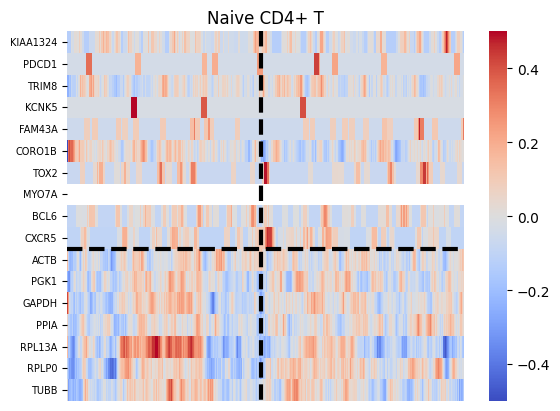

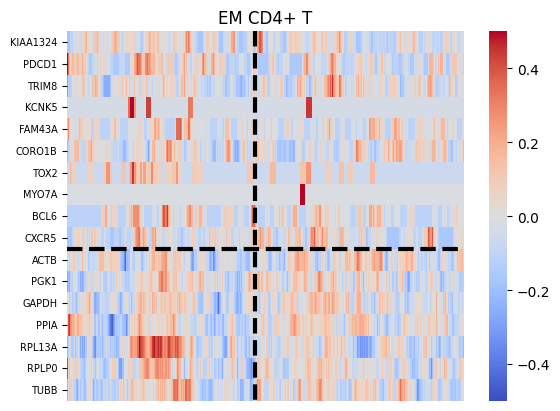

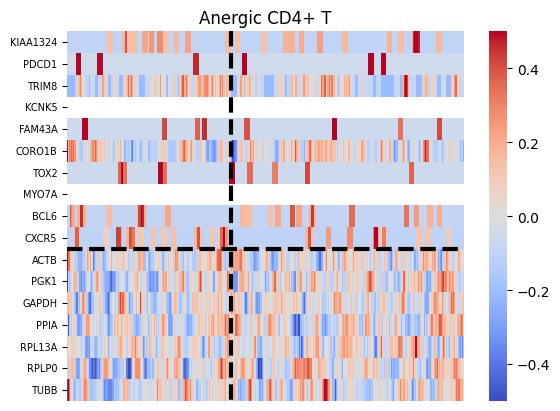

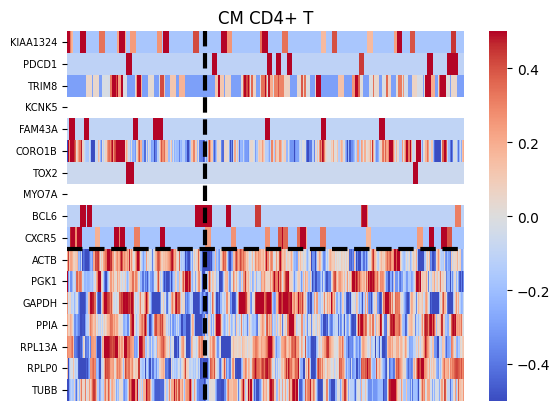

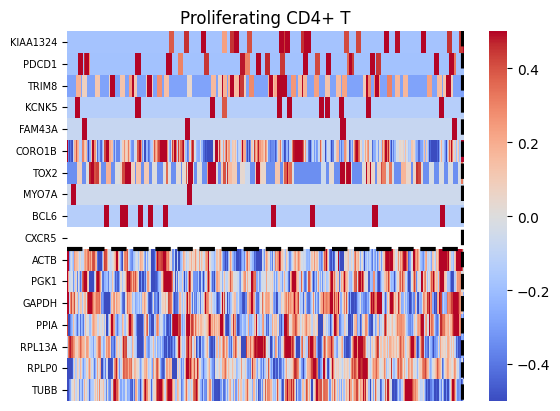

In [15]:
for ct in ct_list:

    if 'CD4' not in ct:
        continue
    plt.figure()
    try:
        get_sc_fs_heatmap(ct, -0.5, 0.5)
    except:
        continue

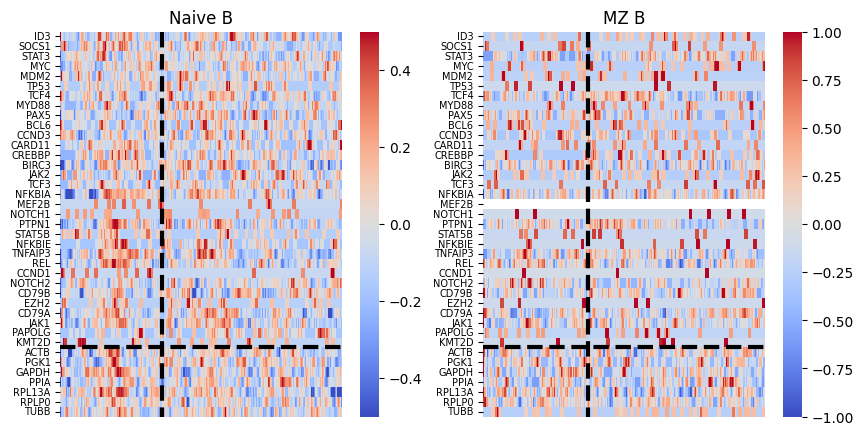

In [262]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
get_sc_fs_heatmap('Naive B', vmax=0.5, vmin=-0.5)
plt.subplot(1, 2, 2)
get_sc_fs_heatmap('MZ B', vmax=1, vmin=-1)

plt.savefig('bcell_lymphoma_genes.png', bbox_inches='tight')

### TfH signature comparisons beteween disease vs control

In [38]:
selected_genes = "PDCD1, CXCR5, TOX2, TRIM8, FAM43A, BCL6, KCNK5, MYO7A, KIAA1324, CORO1B".split(', ')



In [39]:
mdata.obs['pSS']

GN21-SCG1_AAACCTGAGAACAACT-1    0
GN21-SCG1_AAACCTGAGAATGTGT-1    1
GN21-SCG1_AAACCTGAGACCTAGG-1    0
GN21-SCG1_AAACCTGAGGGTCGAT-1    0
GN21-SCG1_AAACCTGAGTACTTGC-1    0
                               ..
GN27-SCG1_TTTGTCATCAGCATGT-1    1
GN27-SCG1_TTTGTCATCCTAGGGC-1    1
GN27-SCG1_TTTGTCATCGGCATCG-1    1
GN27-SCG1_TTTGTCATCTAACGGT-1    1
GN27-SCG1_TTTGTCATCTATCCCG-1    0
Name: pSS, Length: 48518, dtype: int32

In [50]:
for p in mdata.mod['prot'].var.index:
    if 'CD40' in p:
        print(p)

CD40.1
CD40LG.1


In [41]:
tcell_case = mdata[mdata.obs['annotation_merged'].str.contains('CD4') & (mdata.obs['pSS'] == 1), selected_genes].mod['rna'].X.toarray()
tcell_ctrl = mdata[mdata.obs['annotation_merged'].str.contains('CD4') & (mdata.obs['pSS'] == 0), selected_genes].mod['rna'].X.toarray()






In [46]:
pv

array([0.96435076, 0.30506676, 0.34258022, 0.86061291, 0.96302718,
       0.99375232, 0.87093826, 0.97293517, 0.87916038, 0.18111963])

### Protein DE

In [106]:
ct_kwds = ['CD4', 'B', 'Mono', 'CD8']

In [107]:
results = []
for ct in ct_kwds:
    case = mdata[mdata.obs['annotation_merged'].str.contains(ct) & (mdata.obs['pSS'] == 1), ].mod['prot'].X.toarray()
    ctrl = mdata[mdata.obs['annotation_merged'].str.contains(ct) & (mdata.obs['pSS'] == 0), ].mod['prot'].X.toarray()

    df = pd.DataFrame(index=mdata.mod['prot'].var.index)
    _, df['pv'] = stats.ranksums(ctrl, case)

    _, df['fdr'] = fdrcorrection(df['pv'])
    df['effect_size'] = case.mean(axis=0) - ctrl.mean(axis=0)

    df['ct'] = ct

    df = df.query('fdr < 0.01').sort_values('effect_size', ascending=True).head(10)
    results.append(df)
    
    
    


In [108]:
results = pd.concat(results)

In [109]:
hm.shape

(5, 26)

In [110]:
hm = results.query('fdr < 0.1').reset_index()\
    .pivot(index='ct', columns='index', values='effect_size').fillna(0.0)

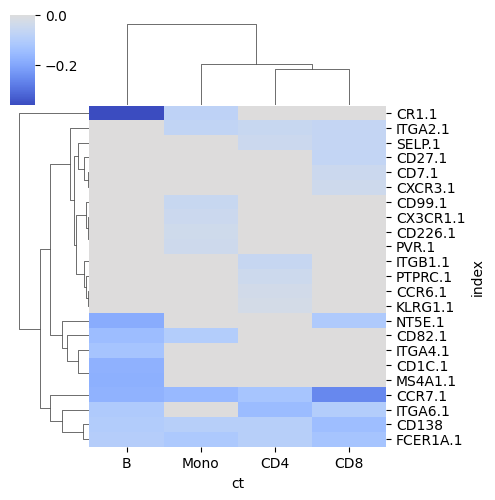

In [111]:
sns.clustermap(hm.T, center=0, cmap='coolwarm', figsize=(5,5), yticklabels=1)

In [68]:
df.query('fdr < 0.01').sort_values('effect_size', ascending=False)

,pv,fdr,effect_size,ct
B3GAT1.1,2.798381e-42,5.556784e-41,0.372813,CD8
ITGAL.1,6.960806e-68,3.225174e-66,0.223392,CD8
ADGRG1.1,3.952148e-27,3.923918e-26,0.172908,CD8
KLRG1.1,2.765070e-27,3.202873e-26,0.172570,CD8
CD99.1,7.785285e-35,1.082155e-33,0.161672,CD8
...,...,...,...,...
ITGA6.1,5.199792e-11,2.258660e-10,-0.099177,CD8
NT5E.1,2.498421e-23,1.827792e-22,-0.108153,CD8
FCER1A.1,1.160170e-62,3.225271e-61,-0.128089,CD8
CD138,7.824452e-80,5.437994e-78,-0.145842,CD8
